# Setup

In [1]:
# ===== 0. Setup =====
import os, shutil, random, json, glob
from pathlib import Path

PROJECT_DIR = Path("/content/airplane_detection")
DATA_DIR    = PROJECT_DIR / "data"
RAW_DIR     = DATA_DIR / "raw"
SUBSET_DIR  = DATA_DIR / "subset"

for d in [PROJECT_DIR, DATA_DIR, RAW_DIR, SUBSET_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("Project:", PROJECT_DIR)


Project: /content/airplane_detection


# Dataset - Download & Extraction

In [2]:
# ===== 1. Download & extract =====
!apt-get -y update >/dev/null
!apt-get -y install p7zip-full aria2 >/dev/null

%cd /content/airplane_detection/data/raw

# Download all 10 parts from Zenodo
# (Zenodo's "Download" links follow a predictable pattern: /files/<filename>?download=1 )
base = "https://zenodo.org/records/14546832/files"
parts = [f"HRPlanes.7z.{i:03d}" for i in range(1, 11)]
urls  = [f"{base}/{p}?download=1" for p in parts]

with open("urls.txt","w") as f:
    f.write("\n".join(urls))

# Multi-connection downloader (faster & more reliable)
!aria2c -c -x 8 -s 8 -i urls.txt

# Extract using the first part (7z will read the rest automatically)
!mkdir -p HRPlanes
!7z x HRPlanes.7z.001 -oHRPlanes >/dev/null

print("Extracted to:", Path("/content/airplane_detection/data/raw/HRPlanes"))
!ls -lah HRPlanes | head -n 50


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
/content/airplane_detection/data/raw

01/15 18:41:21 [NOTICE] Downloading 10 item(s)
 *** Download Progress Summary as of Thu Jan 15 18:42:22 2026 *** 
=
[#154cd8 812MiB/1.0GiB(79%) CN:8 DL:15MiB ETA:13s]
FILE: /content/airplane_detection/data/raw/HRPlanes.7z.001
-
[#159e4c 782MiB/1.0GiB(76%) CN:8 DL:14MiB ETA:16s]
FILE: /content/airplane_detection/data/raw/HRPlanes.7z.002
-
[#2caff2 782MiB/1.0GiB(76%) CN:8 DL:14MiB ETA:16s]
FILE: /content/airplane_detection/data/raw/HRPlanes.7z.003
-
[#ed1cc2 795MiB/1.0GiB(77%) CN:8 DL:14MiB ETA:16s]
FILE: /content/airplane_detection/data/raw/HRPlanes.7z.004
-
[#e91c1b 802MiB/1.0GiB(78%) CN:8 DL:15MiB ETA:14s]
FILE: /content/airplane_detection/data/raw/HRPlanes.7z.005
-


01/15 18:42:43 [NOTICE] Download complete: /content/airplane_detection/data/raw/HRPlanes.7z.001

In [3]:
# ===== 1b. Verify structure =====
root = Path("/content/airplane_detection/data/raw/HRPlanes")

candidates = list(root.glob("**/images"))[:5]
print("Found images dirs like:", candidates)

for split in ["train","val","test"]:
    img_dir = next(iter(root.glob(f"**/images/{split}")), None)
    lbl_dir = next(iter(root.glob(f"**/labels/{split}")), None)
    print(split, "images:", img_dir, "labels:", lbl_dir)


Found images dirs like: []
train images: None labels: None
val images: None labels: None
test images: None labels: None


In [4]:
from pathlib import Path
import os

root = Path("/content/airplane_detection/data/raw/HRPlanes")

print("Root exists:", root.exists())
print("Contents:", [p.name for p in root.iterdir()])

img_dir = root / "img"
print("\nImage dir:", img_dir, "exists:", img_dir.exists())

split_files = {
    "train": root / "train.txt",
    "val": root / "validation.txt",   # note: it's validation.txt (not val.txt)
    "test": root / "test.txt"
}

for k, f in split_files.items():
    print(f"{k} split file:", f, "exists:", f.exists())

def read_split_list(txt_path: Path):
    lines = [l.strip() for l in txt_path.read_text().splitlines() if l.strip()]
    # Many darknet datasets store either absolute paths or relative paths.
    # Convert relative paths to absolute under root.
    abs_paths = []
    for l in lines:
        p = Path(l)
        if not p.is_absolute():
            p = (root / p).resolve()
        abs_paths.append(p)
    return abs_paths

# Read splits and print counts + sample
splits = {}
for split, txt in split_files.items():
    paths = read_split_list(txt)
    splits[split] = paths
    print(f"\n{split}: {len(paths)} images")
    print(" sample:", paths[0] if paths else "EMPTY")

# Check label existence
# Common patterns:
# 1) label is same stem .txt in the same folder as image (img/xxx.jpg -> img/xxx.txt)
# 2) label is under labels/ with same split (not your case, but we check anyway)
labels_dir_candidate = root / "labels"
print("\nlabels dir candidate:", labels_dir_candidate, "exists:", labels_dir_candidate.exists())

def find_label_for_image(img_path: Path):
    # pattern 1: same folder .txt
    p1 = img_path.with_suffix(".txt")
    if p1.exists():
        return p1
    # pattern 2: labels folder mirroring img
    if labels_dir_candidate.exists():
        p2 = labels_dir_candidate / img_path.name
        p2 = p2.with_suffix(".txt")
        if p2.exists():
            return p2
    return None

for split in ["train","val","test"]:
    paths = splits[split]
    missing = 0
    for p in paths[:200]:  # check first 200 to keep fast
        if find_label_for_image(p) is None:
            missing += 1
    print(f"{split}: missing labels in first {min(200, len(paths))} images => {missing}")


Root exists: True
Contents: ['img', 'obj.data', 'validation.txt', 'test.txt', 'train.txt', 'obj.names', 'CITATION.txt']

Image dir: /content/airplane_detection/data/raw/HRPlanes/img exists: True
train split file: /content/airplane_detection/data/raw/HRPlanes/train.txt exists: True
val split file: /content/airplane_detection/data/raw/HRPlanes/validation.txt exists: True
test split file: /content/airplane_detection/data/raw/HRPlanes/test.txt exists: True

train: 2170 images
 sample: /content/airplane_detection/data/raw/HRPlanes/data/plane/img/AMST_001.jpg

val: 620 images
 sample: /content/airplane_detection/data/raw/HRPlanes/data/plane/img/AMST_0012.jpg

test: 311 images
 sample: /content/airplane_detection/data/raw/HRPlanes/data/plane/img/AMST_039.jpg

labels dir candidate: /content/airplane_detection/data/raw/HRPlanes/labels exists: False
train: missing labels in first 200 images => 200
val: missing labels in first 200 images => 200
test: missing labels in first 200 images => 200


# Subset maker

In [6]:
from pathlib import Path

root = Path("/content/airplane_detection/data/raw/HRPlanes")

# find some images anywhere under root
imgs = []
for ext in ["*.jpg", "*.jpeg", "*.png"]:
    imgs += list(root.rglob(ext))

print("Total images found:", len(imgs))
print("First 20 image paths:")
for p in imgs[:20]:
    print(" ", p)

# show unique parent folders of first 200 images
parents = sorted({str(p.parent) for p in imgs[:200]})
print("\nExample image parent folders (up to 20):")
for p in parents[:20]:
    print(" ", p)


Total images found: 3090
First 20 image paths:
  /content/airplane_detection/data/raw/HRPlanes/img/SUV_0206.jpg
  /content/airplane_detection/data/raw/HRPlanes/img/GBG_644.jpg
  /content/airplane_detection/data/raw/HRPlanes/img/GBG_1669.jpg
  /content/airplane_detection/data/raw/HRPlanes/img/JOH_0128.jpg
  /content/airplane_detection/data/raw/HRPlanes/img/IND_095.jpg
  /content/airplane_detection/data/raw/HRPlanes/img/GBG_1602.jpg
  /content/airplane_detection/data/raw/HRPlanes/img/CTU_0027.jpg
  /content/airplane_detection/data/raw/HRPlanes/img/IND_0164.jpg
  /content/airplane_detection/data/raw/HRPlanes/img/GBG_939.jpg
  /content/airplane_detection/data/raw/HRPlanes/img/GBG_688.jpg
  /content/airplane_detection/data/raw/HRPlanes/img/VIC_011.jpg
  /content/airplane_detection/data/raw/HRPlanes/img/DAV_031.jpg
  /content/airplane_detection/data/raw/HRPlanes/img/KUA_075.jpg
  /content/airplane_detection/data/raw/HRPlanes/img/KUA_033.jpg
  /content/airplane_detection/data/raw/HRPlanes/img

In [7]:
from pathlib import Path

root = Path("/content/airplane_detection/data/raw/HRPlanes")

# pick a few images and see if corresponding .txt exists next to them
imgs = []
for ext in ["*.jpg", "*.jpeg", "*.png"]:
    imgs += list((root/"img").glob(ext))

print("Images in HRPlanes/img:", len(imgs))

sample = imgs[:10]
for ip in sample:
    lp = ip.with_suffix(".txt")
    print(ip.name, "label next to it exists:", lp.exists(), "->", lp.name)


Images in HRPlanes/img: 3090
SUV_0206.jpg label next to it exists: True -> SUV_0206.txt
GBG_644.jpg label next to it exists: True -> GBG_644.txt
GBG_1669.jpg label next to it exists: True -> GBG_1669.txt
JOH_0128.jpg label next to it exists: True -> JOH_0128.txt
IND_095.jpg label next to it exists: True -> IND_095.txt
GBG_1602.jpg label next to it exists: True -> GBG_1602.txt
CTU_0027.jpg label next to it exists: True -> CTU_0027.txt
IND_0164.jpg label next to it exists: True -> IND_0164.txt
GBG_939.jpg label next to it exists: True -> GBG_939.txt
GBG_688.jpg label next to it exists: True -> GBG_688.txt


In [8]:
from pathlib import Path

root = Path("/content/airplane_detection/data/raw/HRPlanes")
img_dir = root / "img"

fixed_dir = root / "fixed_splits"
fixed_dir.mkdir(exist_ok=True)

split_files = {
    "train": root / "train.txt",
    "val": root / "validation.txt",
    "test": root / "test.txt"
}

def fix_split(txt_path: Path, out_path: Path):
    lines = [l.strip() for l in txt_path.read_text().splitlines() if l.strip()]
    fixed = []
    missing = 0

    for l in lines:
        fname = Path(l).name   # keep only AMST_001.jpg
        real = img_dir / fname
        if real.exists():
            fixed.append(str(real))
        else:
            missing += 1

    out_path.write_text("\n".join(fixed) + "\n")
    return len(lines), len(fixed), missing

for split, txt in split_files.items():
    total, ok, miss = fix_split(txt, fixed_dir / f"{split}.txt")
    print(f"{split}: original={total}, fixed={ok}, missing={miss}")

print("\nFixed split files saved in:", fixed_dir)


train: original=2170, fixed=2163, missing=7
val: original=620, fixed=617, missing=3
test: original=311, fixed=310, missing=1

Fixed split files saved in: /content/airplane_detection/data/raw/HRPlanes/fixed_splits


In [9]:
import random, shutil
from pathlib import Path

random.seed(42)

root = Path("/content/airplane_detection/data/raw/HRPlanes")
fixed_dir = root / "fixed_splits"

# CHANGE THESE
SUB_SIZES = {"train": 1000, "val": 250, "test": 150}

OUT_ROOT = Path("/content/airplane_detection/data/subset/hrplanes_yolov8")
if OUT_ROOT.exists():
    shutil.rmtree(OUT_ROOT)

def read_list(p: Path):
    return [Path(l.strip()) for l in p.read_text().splitlines() if l.strip()]

def label_path_for_image(img_path: Path):
    return img_path.with_suffix(".txt")  # labels next to images

for split in ["train", "val", "test"]:
    imgs = read_list(fixed_dir / f"{split}.txt")
    n = min(SUB_SIZES[split], len(imgs))
    chosen = random.sample(imgs, n)

    out_img = OUT_ROOT / "images" / split
    out_lbl = OUT_ROOT / "labels" / split
    out_img.mkdir(parents=True, exist_ok=True)
    out_lbl.mkdir(parents=True, exist_ok=True)

    missing_labels = 0
    for ip in chosen:
        shutil.copy2(ip, out_img / ip.name)

        lp = label_path_for_image(ip)
        if lp.exists():
            shutil.copy2(lp, out_lbl / lp.name)
        else:
            (out_lbl / (ip.stem + ".txt")).write_text("")
            missing_labels += 1

    print(f"{split}: copied {n} images. Missing labels: {missing_labels}")

print("\nSubset created at:", OUT_ROOT)


train: copied 1000 images. Missing labels: 5
val: copied 250 images. Missing labels: 1
test: copied 150 images. Missing labels: 0

Subset created at: /content/airplane_detection/data/subset/hrplanes_yolov8


In [10]:
from pathlib import Path

OUT_ROOT = Path("/content/airplane_detection/data/subset/hrplanes_yolov8")
DATA_YAML = Path("/content/airplane_detection/hrplanes_subset.yaml")

DATA_YAML.write_text(f"""
path: {OUT_ROOT}
train: images/train
val: images/val
test: images/test

names:
  0: airplane
""".strip())

print(DATA_YAML.read_text())


path: /content/airplane_detection/data/subset/hrplanes_yolov8
train: images/train
val: images/val
test: images/test

names:
  0: airplane


# YOLO v8

In [11]:
!pip -q install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 26.4 MB/s eta 0:00:00


In [12]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  # small + fast
model.train(
    data=str(DATA_YAML),
    epochs=50,
    imgsz=640,
    batch=8,
    device=0
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.4.2 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/airplane_detection/hrplanes_subset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7bff48435700>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [13]:
from ultralytics import YOLO

# Load the best trained model from the runs directory
model = YOLO('/content/airplane_detection/data/raw/runs/detect/train/weights/best.pt')


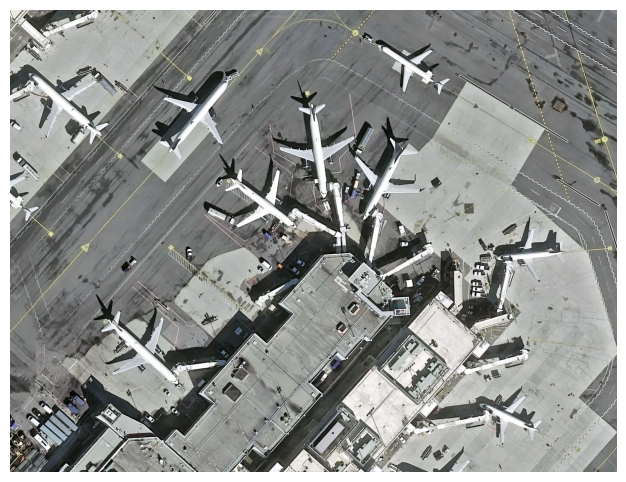

In [14]:
import cv2
import matplotlib.pyplot as plt

# Load a new image (change the path to your image)
img_path = "/content/airplane.jpg"  # Change this path to your image file

# Read image using OpenCV (BGR format)
img = cv2.imread(img_path)

# Convert BGR to RGB for visualization
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()



image 1/1 /content/airplane.jpg: 512x640 10 airplanes, 6.9ms
Speed: 3.5ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'airplane'}
obb: None
orig_img: array([[[154, 166, 168],
        [205, 217, 219],
        [234, 243, 246],
        ...,
        [118, 117, 113],
        [132, 131, 127],
        [131, 128, 124]],

       [[122, 134, 136],
        [186, 198, 200],
        [235, 244, 247],
        ...,
        [110, 109, 105],
        [110, 109, 105],
        [124, 121, 117]],

       [[ 97, 109, 111],
        [156, 168, 170],
        [230, 239, 242],
        ...,
        [117, 114, 110],
        [106, 103,  99],
        [108, 105, 101]],

       ...,

       [[104, 132, 139],
        [ 81, 107, 114],
        [ 82, 105, 113],
        ...,
        [128, 132, 126],
        [129, 133, 127],
        [128, 132

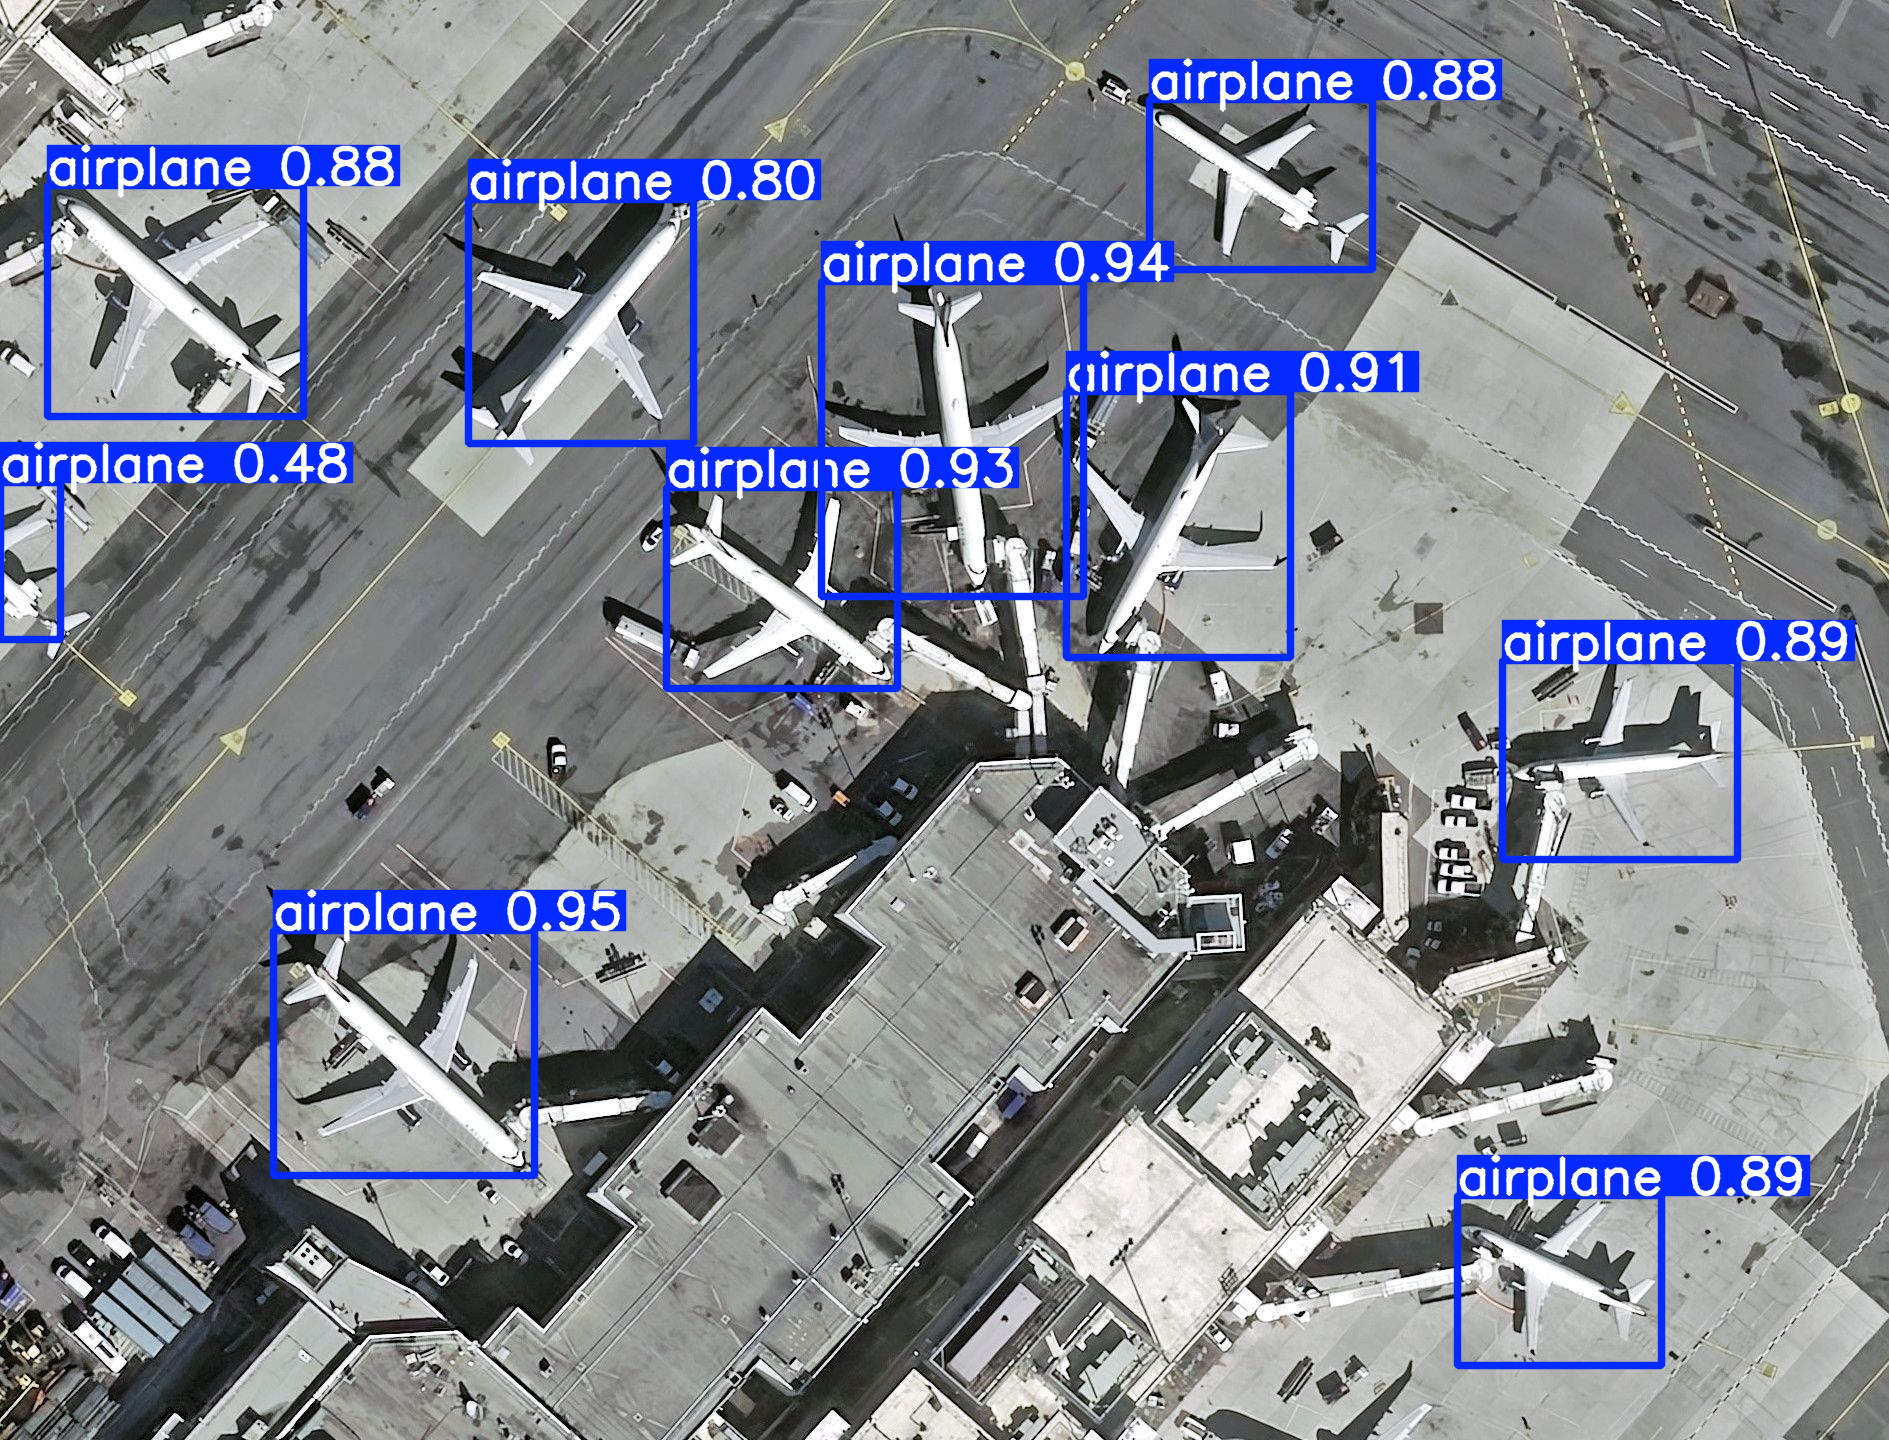

In [16]:
# Perform inference on the new image
results = model(img_path)

# Print results (this will show detected classes, confidence scores, and bounding boxes)
print(results)

# Visualize the results
results[0].show()  # This will show the image with bounding boxes drawn

In [19]:
# Save the image with detecting boxes
saved_image_path = "/content/airplane_YOLOv8.jpg" # You can change the path and filename
results[0].save(saved_image_path)

print(f"Image with detections saved to: {saved_image_path}")

Image with detections saved to: /content/airplane_YOLOv8.jpg


# Fater R-CNN

In [20]:
# Install required libraries
!pip install torch torchvision matplotlib


In [28]:
import os
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms import functional as F

class AirplaneDetectionDataset(Dataset):
    def __init__(self, root_dir, split="train"):
        self.root_dir = root_dir
        self.split = split
        self.img_dir = os.path.join(root_dir, "images", split)
        self.lbl_dir = os.path.join(root_dir, "labels", split)

        self.image_paths = [
            os.path.join(self.img_dir, f)
            for f in os.listdir(self.img_dir)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))
        ]
        self.image_paths.sort()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        W, H = img.size

        base = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(self.lbl_dir, base + ".txt")

        boxes_list = []
        labels_list = []

        if os.path.exists(label_path):
            for line in open(label_path, "r"):
                line = line.strip()
                if not line:
                    continue
                parts = line.split()
                if len(parts) != 5:
                    continue

                _, xc, yc, bw, bh = parts
                xc, yc, bw, bh = map(float, [xc, yc, bw, bh])

                # YOLO -> xyxy in pixels
                x1 = (xc - bw/2) * W
                y1 = (yc - bh/2) * H
                x2 = (xc + bw/2) * W
                y2 = (yc + bh/2) * H

                # clamp
                x1 = max(0.0, min(x1, W - 1.0))
                y1 = max(0.0, min(y1, H - 1.0))
                x2 = max(0.0, min(x2, W - 1.0))
                y2 = max(0.0, min(y2, H - 1.0))

                # filter degenerate
                if (x2 - x1) >= 1.0 and (y2 - y1) >= 1.0:
                    boxes_list.append([x1, y1, x2, y2])
                    labels_list.append(1)  # airplane=1 (0 is background)

        boxes = torch.as_tensor(boxes_list, dtype=torch.float32).reshape(-1, 4)
        labels = torch.as_tensor(labels_list, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
        }

        # IMPORTANT: just ToTensor (0..1). No Normalize/Resize here.
        img_tensor = F.to_tensor(img)
        return img_tensor, target


In [29]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    return tuple(zip(*batch))

DATA_ROOT = "/content/airplane_detection/data/subset/hrplanes_yolov8"

train_dataset = AirplaneDetectionDataset(DATA_ROOT, split="train")
val_dataset   = AirplaneDetectionDataset(DATA_ROOT, split="val")

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=2, collate_fn=collate_fn)

print("Train images:", len(train_dataset), "Val images:", len(val_dataset))


Train images: 1000 Val images: 250


In [30]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)  # bg + airplane
model.to(device)

print("Device:", device)


Device: cuda


In [31]:
import torch

def sanity_check(ds, n=200):
    for i in range(min(n, len(ds))):
        img, tgt = ds[i]
        boxes = tgt["boxes"]
        if boxes.numel() > 0:
            if boxes.ndim != 2 or boxes.shape[1] != 4:
                raise ValueError(f"Bad box shape at idx {i}: {boxes.shape}")
            if not torch.isfinite(boxes).all():
                raise ValueError(f"Non-finite boxes at idx {i}")
            if (boxes[:, 2] <= boxes[:, 0]).any() or (boxes[:, 3] <= boxes[:, 1]).any():
                raise ValueError(f"Degenerate box at idx {i}: {boxes}")
        if not torch.isfinite(img).all():
            raise ValueError(f"Non-finite image tensor at idx {i}")
    print("Sanity check passed for first", min(n, len(ds)), "samples")

sanity_check(train_dataset, n=300)


Sanity check passed for first 300 samples


In [32]:
import torch.optim as optim
from tqdm import tqdm
import math

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, targets in pbar:
        images  = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # NaN/Inf guard
        if not torch.isfinite(losses):
            print("Non-finite loss detected. Loss dict:", {k: float(v) for k,v in loss_dict.items()})
            raise ValueError("Stopping due to NaN/Inf loss")

        optimizer.zero_grad()
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10.0)  # helps stability
        optimizer.step()

        running_loss += losses.item()
        pbar.set_postfix(loss=float(losses.item()))

    lr_scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

torch.save(model.state_dict(), "/content/airplane_detection/fasterrcnn_airplane.pt")
print("Training completed! Saved to /content/airplane_detection/fasterrcnn_airplane.pt")


Epoch 1/5: 100%|██████████| 500/500 [07:54<00:00,  1.05it/s, loss=0.384]


Epoch 1/5, Loss: 0.2929


Epoch 2/5: 100%|██████████| 500/500 [07:49<00:00,  1.06it/s, loss=0.108]


Epoch 2/5, Loss: 0.1849


Epoch 3/5: 100%|██████████| 500/500 [07:53<00:00,  1.06it/s, loss=0.036]


Epoch 3/5, Loss: 0.1520


Epoch 4/5: 100%|██████████| 500/500 [07:50<00:00,  1.06it/s, loss=0.186]


Epoch 4/5, Loss: 0.1298


Epoch 5/5: 100%|██████████| 500/500 [07:53<00:00,  1.06it/s, loss=0.116]


Epoch 5/5, Loss: 0.1206
Training completed! Saved to /content/airplane_detection/fasterrcnn_airplane.pt


In [33]:
import torch
from torch.utils.data import DataLoader

# Use the same dataset class you used for training
# (Assumes AirplaneDetectionDataset and collate_fn are already defined in your notebook)

DATA_ROOT = "/content/airplane_detection/data/subset/hrplanes_yolov8"

test_dataset = AirplaneDetectionDataset(DATA_ROOT, split="test")
test_loader  = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=2, collate_fn=collate_fn)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreate model architecture and load weights
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = fasterrcnn_resnet50_fpn(weights=None)  # weights=None since you're loading your own
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)
model.load_state_dict(torch.load("/content/airplane_detection/fasterrcnn_airplane.pt", map_location=device))
model.to(device)
model.eval()

print("Test images:", len(test_dataset))


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 184MB/s]


Test images: 150


In [34]:
!pip -q install pycocotools


In [35]:
import numpy as np
import torch
from tqdm import tqdm
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json, tempfile

def coco_gt_from_dataset(ds):
    """
    Build COCO GT dict from dataset:
    - 1 category: airplane (id=1)
    - images: id = dataset index
    - annotations: bbox in COCO format [x,y,width,height]
    """
    coco = {
        "images": [],
        "annotations": [],
        "categories": [{"id": 1, "name": "airplane"}],
    }
    ann_id = 1

    for i in range(len(ds)):
        img_tensor, target = ds[i]
        _, H, W = img_tensor.shape

        coco["images"].append({
            "id": i,
            "file_name": f"{i}.jpg",
            "width": W,
            "height": H
        })

        boxes = target["boxes"].numpy() if target["boxes"].numel() else np.zeros((0,4), dtype=np.float32)
        labels = target["labels"].numpy() if target["labels"].numel() else np.zeros((0,), dtype=np.int64)

        for b, lab in zip(boxes, labels):
            # lab should be 1 for airplane
            x1, y1, x2, y2 = b.tolist()
            w = max(0.0, x2 - x1)
            h = max(0.0, y2 - y1)
            coco["annotations"].append({
                "id": ann_id,
                "image_id": i,
                "category_id": int(lab),
                "bbox": [x1, y1, w, h],
                "area": float(w * h),
                "iscrowd": 0
            })
            ann_id += 1

    return coco

@torch.no_grad()
def coco_predictions_from_model(model, ds, score_thresh=0.05):
    """
    Return COCO detections list with fields:
    image_id, category_id, bbox[x,y,w,h], score
    """
    preds = []
    for i in tqdm(range(len(ds)), desc="Predict test"):
        img, _ = ds[i]
        out = model([img.to(device)])[0]

        boxes = out["boxes"].detach().cpu().numpy()
        scores = out["scores"].detach().cpu().numpy()
        labels = out["labels"].detach().cpu().numpy()

        keep = scores >= score_thresh
        boxes, scores, labels = boxes[keep], scores[keep], labels[keep]

        for b, s, lab in zip(boxes, scores, labels):
            x1, y1, x2, y2 = b.tolist()
            w = max(0.0, x2 - x1)
            h = max(0.0, y2 - y1)
            preds.append({
                "image_id": i,
                "category_id": int(lab),
                "bbox": [x1, y1, w, h],
                "score": float(s)
            })
    return preds

# Build COCO GT and predictions
gt_dict = coco_gt_from_dataset(test_dataset)
dt_list = coco_predictions_from_model(model, test_dataset, score_thresh=0.05)

# Evaluate with COCOeval using temp json files
with tempfile.TemporaryDirectory() as tmp:
    gt_path = f"{tmp}/gt.json"
    dt_path = f"{tmp}/dt.json"
    json.dump(gt_dict, open(gt_path, "w"))
    json.dump(dt_list, open(dt_path, "w"))

    coco_gt = COCO(gt_path)
    coco_dt = coco_gt.loadRes(dt_path)

    coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    # Useful metrics:
    # stats[0] = mAP@[.50:.95]
    # stats[1] = mAP@0.50
    # stats[2] = mAP@0.75
    print("\nKey metrics:")
    print("mAP@[0.50:0.95] =", float(coco_eval.stats[0]))
    print("mAP@0.50        =", float(coco_eval.stats[1]))
    print("mAP@0.75        =", float(coco_eval.stats[2]))


Predict test: 100%|██████████| 150/150 [01:17<00:00,  1.94it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.32s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.787
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.978
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.951
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.720
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.678
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.795
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.133
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.625
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

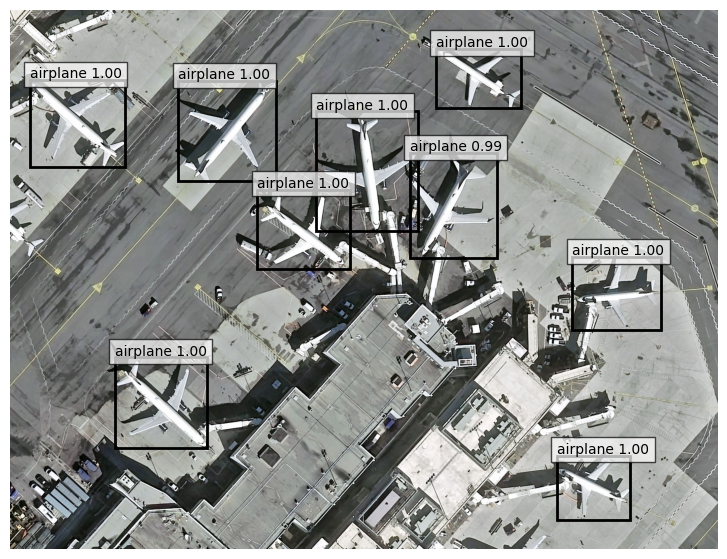

In [36]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torchvision.transforms import functional as F

def predict_and_plot(img_path, conf_thresh=0.25, show_labels=True):
    # Load image
    img = Image.open(img_path).convert("RGB")
    img_tensor = F.to_tensor(img).to(device)  # [0,1] float

    # Inference
    with torch.no_grad():
        output = model([img_tensor])[0]

    boxes = output["boxes"].detach().cpu()
    scores = output["scores"].detach().cpu()
    labels = output["labels"].detach().cpu()

    # Filter by confidence
    keep = scores >= conf_thresh
    boxes = boxes[keep]
    scores = scores[keep]
    labels = labels[keep]

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    ax.imshow(img)
    for (x1, y1, x2, y2), s, lab in zip(boxes, scores, labels):
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, linewidth=2)
        ax.add_patch(rect)
        if show_labels:
            name = "airplane" if int(lab) == 1 else str(int(lab))
            ax.text(
                x1, max(0, y1 - 5),
                f"{name} {float(s):.2f}",
                fontsize=10,
                bbox=dict(facecolor="white", alpha=0.7)
            )

    ax.axis("off")
    plt.show()

    # Return raw results too
    return output

# Example (use your own new image path here)
img_path = "/content/airplane.jpg"
out = predict_and_plot(img_path, conf_thresh=0.25)


In [37]:
import os

def save_prediction_image(img_path, save_path="/content/airplane_fasterrcnn.jpg", conf_thresh=0.25):
    img = Image.open(img_path).convert("RGB")
    img_tensor = F.to_tensor(img).to(device)

    with torch.no_grad():
        output = model([img_tensor])[0]

    boxes = output["boxes"].detach().cpu()
    scores = output["scores"].detach().cpu()

    keep = scores >= conf_thresh
    boxes = boxes[keep]
    scores = scores[keep]

    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    ax.imshow(img)
    for (x1, y1, x2, y2), s in zip(boxes, scores):
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, linewidth=2)
        ax.add_patch(rect)
        ax.text(x1, max(0, y1 - 5), f"{float(s):.2f}", bbox=dict(facecolor="white", alpha=0.7))
    ax.axis("off")

    fig.savefig(save_path, bbox_inches="tight", dpi=150)
    plt.close(fig)
    print("Saved to:", save_path)

save_prediction_image(img_path, save_path="/content/airplane_fasterrcnn.jpg", conf_thresh=0.25)


Saved to: /content/airplane_fasterrcnn.jpg
